# Fandango Movie Ratings: What Has Changed after the Bias Accusations

Online movie ratings aggregators have recently become extremely popular. Top of them are: [Rotten Tomatoes](https://www.rottentomatoes.com/), [Metacritic](https://www.metacritic.com/) and [IMDb](https://www.imdb.com/), each one having a unique way of aggregating film ratings and reviews. Many of these systems calculate [an approximate average assessment](https://en.wikipedia.org/wiki/Review_aggregator), usually based on assigning a numeric value to each review related to its degree of positive rating of the work. Since aggregated scores can easily be a decisive factor for the choice in favor of one or another film, thus influencing sales, the question of *how objectively they are calculated* becomes relevant. More than that Fandango has an immediate interest in customers' choice: the website directly sells tickets.

In October 2015, a data journalist named **Walt Hickey** analyzed movie ratings data from another online movie ratings aggregator **Fandango** and found enough evidence to suggest that Fandango's rating system was biased. He published his analysis [in this article](https://fivethirtyeight.com/features/fandango-movies-ratings/).

On their website Fandango displays a 5-star rating system, with the minimum rating being 0 stars and the maximum 5 stars.

Hickey found that there's a significant inconsistency between the rating showed to users and the actual rating, which could be found in the HTML of the page. 

He was able to find that:

 - The actual rating was almost always rounded up to the nearest half-star. For instance, a 4.1 movie would be rounded off to 4.5 stars, not to 4 stars, as you may expect.
 - In the case of 8% of the ratings analyzed, the rounding up was done to the nearest whole star. For instance, a 4.5 rating would be rounded off to 5 stars.
 - For one movie rating, the rounding off was completely bizarre: from a rating of 4 in the HTML of the page to a displayed rating of 5 stars.
 
After Hickey sent a request to Fandango's officials they replied that the bias in rounding was caused by a bug in their system. They promised to fix it as soon as possible. We can't check if that has happened in the same way as the author of the article  found that bug out since the actual rating value doesn't seem to be displayed anymore in the pages' HTML.

In this project my aim is to **analyze more recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis.**

## Data sets

Walt Hickey made the data he analyzed publicly available [on GitHub](https://github.com/fivethirtyeight/data/tree/master/fandango). I'll use this data to analyze the characteristics of Fandango's rating system previous to his analysis.

One of Dataquest's team members collected movie ratings data for movies released in 2016 and 2017. The data is publicly available [on GitHub](https://github.com/mircealex/Movie_ratings_2016_17) and I'll use it as a reference for the rating system's characteristics after Hickey's analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

rat_before = pd.read_csv('fandango_score_comparison.csv')
rat_after = pd.read_csv('movie_ratings_16_17.csv')

In [2]:
# leave only necessary columns
rat_before = rat_before.loc[: , ['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference']]

In [3]:
# leave only necessary columns
rat_after = rat_after.loc[:, ['movie', 'year', 'fandango']]

## What is the target population?

`fandango_score_comparison.csv` contains every film that has a Rotten Tomatoes rating, a Metacritic score, a Metacritic User score, and IMDb score, and *at least 30* reviews on Fandango. The data from Fandango was pulled on Aug. 24, 2015.

`movie_ratings_16_17.csv` contains movie ratings data for 214 of the most popular movies (with a significant number of votes) released in 2016 and 2017. As of March 22, 2017, the ratings were up to date. Significant changes in ratings since that time period could happen mostly for movies released in 2017.

 
## Changed goal of the analysis

Datasets represent data on the most popular films. The sampling process was not random, so it can only represent information about **most popular films**.

With the new goal, I will choose two populations to describe and compare with each other:

 - All Fandango's ratings for popular movies released in 2015.
 - All Fandango's ratings for popular movies released in 2016.

The term "popular" is vague and needs to be more precise. I’ll use Hickey's benchmark and consider a movie as "popular" only if it has 30 reviews or more on Fandango website.

### Isolating the Sample


Although one of the sampling criteria in our second sample is movie popularity, the sample doesn't provide information about the number of fan ratings. We should be skeptical once more and ask whether this sample is truly representative and contains popular movies (movies with over 30 fan ratings).

One quick way to check the representativity of this sample is to sample randomly 10 movies from it and then check the number of fan ratings ourselves on Fandango's website. Ideally, at least 8 out of the 10 movies have 30 fan ratings or more.

In [4]:
# choose a random sample
rat_after.sample(10, random_state = 1)

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


Above I've used a value of 1 as the random seed. This is good practice because it suggests that I wasn't trying out various random seeds just to get a favorable sample.

As of April 2018, these are the fan ratings we found:

 |Movie |	Fan ratings|
 |---|---|
 |Mechanic: Resurrection|	2247|
 |---|---|
|Warcraft|	7271|
|Max Steel|	493|
|Me Before You|	5263|
|Fantastic Beasts and Where to Find Them|	13400|
|Cell|	17|
|Genius|	127|
|Sully|	11877|
|A Hologram for the King|	500|
|Captain America: Civil War|	35057|


90% of the movies in the sample are popular. This is enough and we move forward with a bit more confidence.

Let's also double-check the other data set for popular movies. The documentation states clearly that there are only movies with at least 30 fan ratings, but it should take only a couple of seconds to double-check here.

In [5]:
(rat_before['Fandango_votes'] < 30).sum()

0

As I was stating before, I am only interested in film released in 2015 and 2016 for `rat_before` and `rat_after` respectively.

In [6]:
# leave movies released at 2015 in rat_before
mask_2015 = rat_before['FILM'].str.contains('\(2015\)')
rat_2015 = rat_before[mask_2015].copy()

In [7]:
# leave movies released at 2016 in rat_after
rat_2016 = rat_after[rat_after['year'] == 2016].copy()

## Comparing distributions of ratings for 2015 and 2016

First step is a high-level comparison between the shapes of the distributions of movie ratings for both samples.

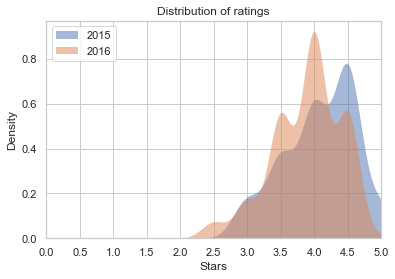

In [8]:
# match kde plots

# plot for 2015
sns.kdeplot(data = rat_2015, x = 'Fandango_Stars', fill=True,
   alpha=.5, linewidth=0, label=2015, legend = True)

# plot for 2016
sns.kdeplot(data = rat_2016, x = 'fandango',
   fill=True, alpha=.5, linewidth=0, label = '2016', legend = True)

plt.title('Distribution of ratings')
plt.xlabel('Stars')
plt.xlim(0, 5)
plt.xticks(np.arange(0, 5.5, step=0.5))
plt.legend(loc=2)

Both distributions are skewed to the left, but the distribution for 2015 is more skewed as for 2016.
Most distributions show that popular movies tend to get high or very high ratings, but ratings from 2016 are relatively lower and start from 2 stars (not from 2.5 stars as for 2015).

There was a change in ratings after the article was published and moved in the direction of lower ratings.
Since the number of films in the both samples are different (129 films for 2015 and 191 for 2016) it's better to focus on proportional distribution of ratings.

## Frequency distribution of ratings


In [9]:
rat_2015['Fandango_Stars'].value_counts(normalize=True)

4.5    0.379845
4.0    0.286822
3.5    0.178295
3.0    0.085271
5.0    0.069767
Name: Fandango_Stars, dtype: float64

In [10]:
rat_2016['fandango'].value_counts(normalize = True)

4.0    0.403141
4.5    0.246073
3.5    0.240838
3.0    0.073298
2.5    0.031414
5.0    0.005236
Name: fandango, dtype: float64

Observations on frequency tables confirm what I found out for cumulative distributions:
 - proportion of films with 5 starts decreased from circa 7% for 2015 to 0.5% for 2016
 - for 2016 most numerous group is with 4 starts (40% for 2016 vs 29% for 2015) while for 2015 more often films were rated with 4.5 stars (38% vs 25% for 2016) 
 - the lowest rating for 2015 was 3 stars while for 2016 3% of films got 2.5 stars

## Summary statistics

 I’lll take each distribution of movie ratings and compute its mean, median, and mode, and then compare these statistics to determine what they tell about the direction of the difference.

In [11]:
# descriptive statistics for 2015
mean_2015 = rat_2015['Fandango_Stars'].mean()
mode_2015 = rat_2015['Fandango_Stars'].mode()[0]
median_2015 = rat_2015['Fandango_Stars'].median()

In [12]:
# descriptive statistics for 2016
mean_2016 = rat_2016['fandango'].mean()
median_2016 = rat_2016['fandango'].median()
mode_2016 = rat_2016['fandango'].mode()[0]

In [13]:
summary = pd.DataFrame()
summary['2015'] = [mean_2015, median_2015, mode_2015]
summary['2016'] = [mean_2016, median_2016, mode_2016]
summary.index = ['mean', 'median', 'mode']

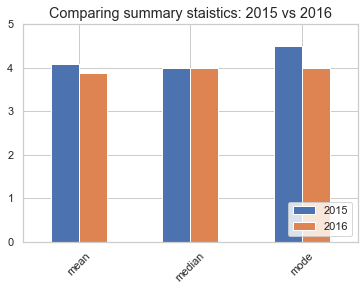

In [15]:
summary.plot(kind='bar')
plt.xticks(rotation=45)
plt.ylim(0, 5)
plt.title('Comparing summary staistics: 2015 vs 2016', fontsize='large')
plt.legend(loc='lower right')

# Conclusion

Our analysis showed that *there was indeed a slight difference* between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016:
 - lowest ratings start from 2.5 for 2015 and from 2.0 for 2016
 - on average, popular movies released in 2016 were rated **lower** on Fandango than popular movies released in 2015
 
Still for both years popular releases tend to get high or very high ratings.